In [9]:
import inspect
import pandas as pd
import numpy as np

from gensim.scripts import glove2word2vec
from gensim.models import KeyedVectors
from gensim import matutils
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import multivariate_normal

from random import choice, shuffle
from random import randint

import networkx as nx
import igraph
import matplotlib.pyplot as plt
from matplotlib import pylab
import community
%matplotlib inline

## Get the Data
First step in using this notebook is getting the pretrained embedded space you wish to use or training your own.
The spaces used in the accompanying paper can be found here:
<br /> Glove - https://nlp.stanford.edu/projects/glove/
<br /> Skip-Gram - https://code.google.com/archive/p/word2vec/

In [3]:
## Use this to convert Glove vector space to be used in Gensim
# glove2word2vec.glove2word2vec('glove.840B.300d.txt', 'glove2word2vec.840B.300d.txt')

In [4]:
source = 'glove2word2vec.840B.300d.txt' #Load whatever embedded space you wish to use here

# Loading our space twice since we will be changing the temp version
model = KeyedVectors.load_word2vec_format(source, binary=False)
temp = KeyedVectors.load_word2vec_format(source, binary=False)

In [5]:
model

### Regular model similarity

In [6]:
# Run a Gensim query to get normalized vectors in model.syn0norm
model.most_similar(positive=['Marseille', 'England'], negative=['France'])

[('Liverpool', 0.6906125545501709),
 ('Manchester', 0.6513763666152954),
 ('Leeds', 0.6187247037887573),
 ('Sunderland', 0.6116386651992798),
 ('Middlesbrough', 0.6052476763725281),
 ('Southampton', 0.6049976348876953),
 ('Norwich', 0.5992396473884583),
 ('Newcastle', 0.598601222038269),
 ('Wigan', 0.5768256187438965),
 ('Portsmouth', 0.5756195783615112)]

## Plotting
Visualizing a vector space in 2d can help see how our entities cluster together. An optional clusters argument could be added to our function in order to plot cluster centers in addition to entities

In [12]:
def plot_projected_space(model, centers = None):
    num_points = 500
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000)
    #nemb = tf.nn.l2_normalize(self._w_in, 1)
    two_d_embeddings = tsne.fit_transform(model.syn0norm[1:num_points+1, :])
    if centers is not None:
        two_d_centers = tsne.fit_transform(centers)

    def plot(embeddings, labels, centers = None):
        assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
        pylab.figure(figsize=(15,15))  # in inches
        if centers is not None:
            for c in centers:
                x, y = c
                pylab.scatter(x, y)
                pylab.annotate("Cluster_middle!!!", xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            pylab.scatter(x, y)
        for i, label in enumerate(labels):
            x, y = embeddings[i,:]
            pylab.scatter(x, y)
            pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        pylab.show()

    words = list(model.vocab.keys())[1:num_points+1]
    if centers is not None:
        plot(two_d_embeddings, words, two_d_centers)
    else:
        plot(two_d_embeddings, words)

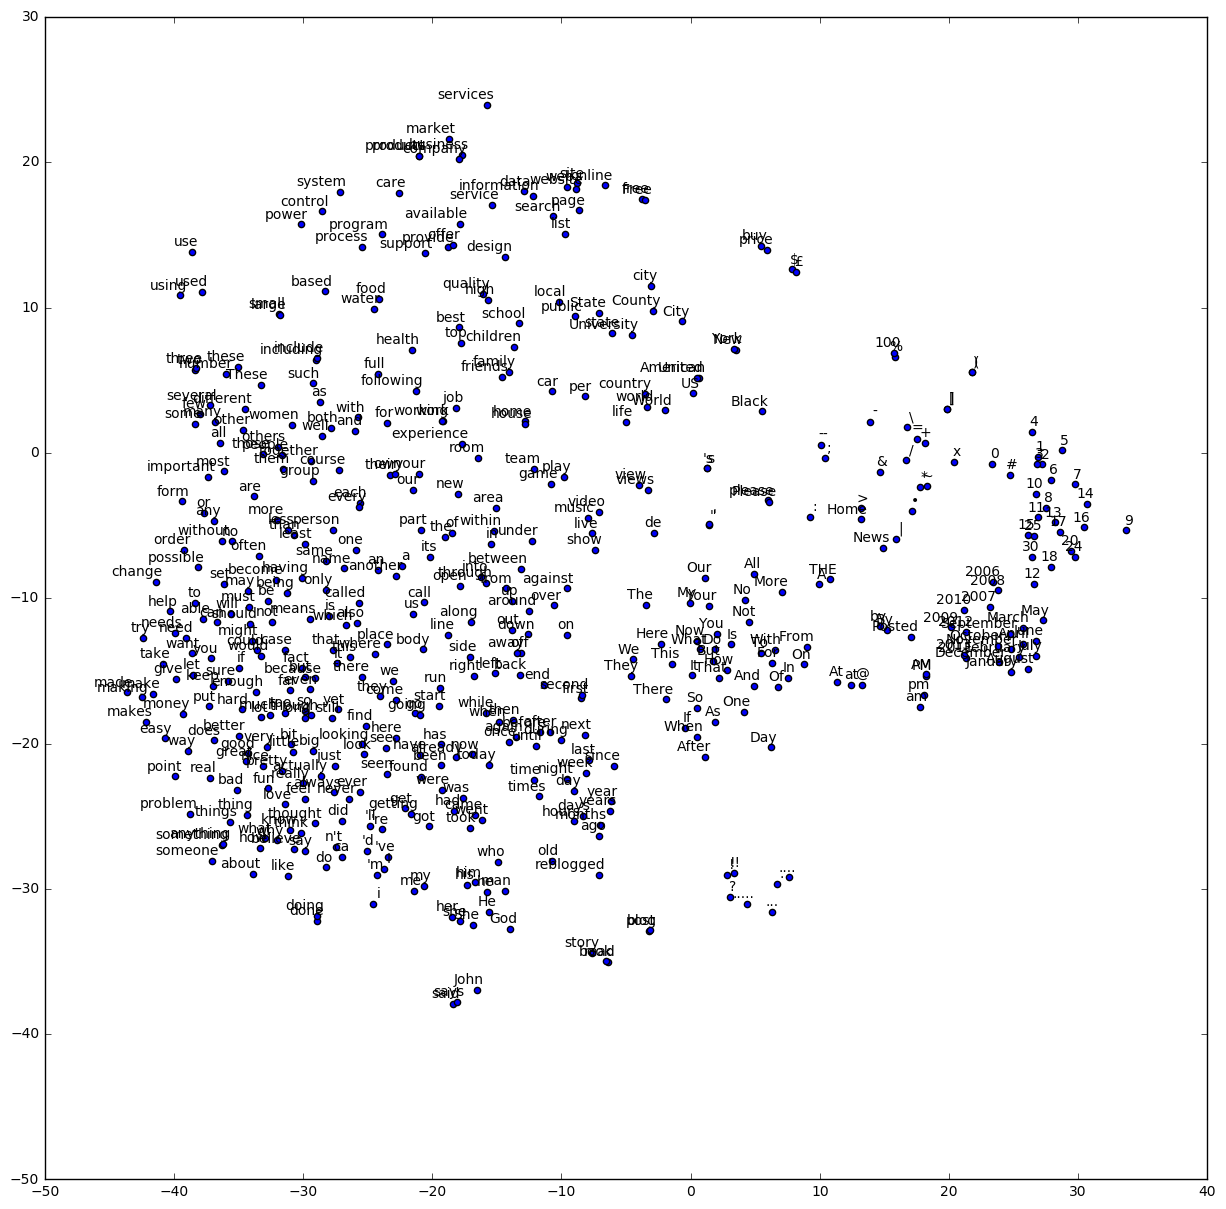

In [14]:
plot_projected_space(model)

## Looking for entities
The following two functions define our one-one relation extraction and one-N relation extraction algorithm.
The two functions make for the bootstrapping process of our model.

In [85]:
def find_one_one(word = 'belgian', thresh = 0.6):

    # For a random seed word, uncomment and fill in size of space 
    # size_of_space = 2999999
    # rand = randint(0,size_of_space)
    # word = model.index2word[rand]

    set_list = []
    error = 0

    sim = [x[0] for x in model.similar_by_vector(word, topn=100) if x[0].lower() != word.lower()]
    for s in sim:
        temp_set = set()
        entities = [word.lower(), s.lower()]
        vec1 = model[word]
        vec2 = model[s]
        other_sim = [x[0] for x in model.similar_by_vector(vec2-vec1, topn=1000) if x[0].lower() not in entities]
        print('**************')
        print("Relation is: " + word + "," + s)
        temp_set.add((word, s))

        for o in other_sim:
            entities.append(o.lower())
            vec4 = model[o]
            temp_str = [x[0] for x in model.most_similar(positive=[word, o], negative=[s])][0]
            vec3 = model[temp_str]

            if (1 - spatial.distance.cosine(vec1 - vec2, vec3 - vec4)) >= thresh:
                print("Discovered: " + temp_str + "," + o)
                temp_set.add((temp_str, o))
                error += np.sum(np.square((vec1 - vec2 + vec4) - vec3))
            else:
                break

        if len(temp_set) > 2:
            set_list.append((temp_set,error/len(temp_set)))
        error = 0
    
    set_list.sort(key=len, reverse=True)
    return set_list

In [16]:
def find_n_one(word = 'Lyon', s = 'France', thresh = 0.6):

    # For a random seed word and seed tail, uncomment and fill in size of space 
    # size_of_space = 2999999
    # rand = randint(0,size_of_space)
    # word = model.index2word[rand]
    # s = model.index2word[rand]

    set_list = []
    error = 0


    temp_set = set()
    entities = [word.lower(), s.lower()]
    vec1 = model[word]
    vec2 = model[s]
    other_sim = [x[0] for x in model.similar_by_vector(vec1, topn=1000000) if x[0].lower() not in entities]
    print('**************')
    print("Relation is: " + word + "," + s)
    temp_set.add((word, s))

    for o in other_sim:
        entities.append(o.lower())
        vec4 = model[s]
        temp_str = o
        vec3 = model[temp_str]

        if (1 - spatial.distance.cosine(vec1 - vec2, vec3 - vec4)) >= thresh:
            print("Discovered: " + o + "," + s)
            temp_set.add((o, s))
            error += np.sum(np.square((vec1 - vec2 + vec4) - vec3))
        else:
            break

    if len(temp_set) > 2:
        set_list.append((temp_set,error/len(temp_set)))
    error = 0
    
    set_list.sort(key=len, reverse=True)
    return set_list

### Expand sets of related entities
The following function is our algorithm for expanding sets of related entities and finding more entities of the same shared relation

In [17]:
def expand_set(words, threshhold = 0.6):
    numFeatures = 250
    priors = []
    
    for w in words:
        priors.append(model[w])
    
    
    # Create a mean vector for the "Prior Knowledge"
    vectors = np.vstack(priors).astype('float32')
    mean = matutils.unitvec(vectors.mean(axis=0)).astype('float32')

    cov = np.cov(np.array(vectors).T)
    #inv_cov = np.linalg.inv(cov)

    # Check strength of belonging to this group
    dists = np.dot(vectors, mean)
    
    #A combinatorial iteration over pairs 
    import itertools
    vecs = priors
    setlist = []

    for x in itertools.combinations(vecs,2):
        setlist.append(set(np.abs(x[0] - x[1]).argsort()[:numFeatures]))

    idx = list(set.intersection(*setlist))

    print('# Common fetures: ' + str(len(idx)))

    red_model = model.syn0norm[:,idx]
    temp.syn0norm = red_model
    
    # find similar
    final = set()
    for w in priors:
        for word in [x[0] for x in temp.similar_by_vector(w[idx], topn=1000, restrict_vocab=None)]:
            dist = np.dot(matutils.unitvec(model[word]).astype('float32'), mean)
            if dist >= threshhold:
#                 print(word, dist)
                final.add(word)
    return final

## Example use
In order to find a triplet (A,r,B) where a one-one relation exist between A and B entities, we use the function find_one_one and pass a seed word and desired threshold. The function can be used to randomly seed the bootstrapping process, or just feed each entity as seed iteratively.

In [91]:
bootstraped = find_one_one(word = 'Amsterdam', thresh=0.5)

**************
Relation is: Amsterdam,Rotterdam
**************
Relation is: Amsterdam,Utrecht
**************
Relation is: Amsterdam,Antwerp
**************
Relation is: Amsterdam,Netherlands
Discovered: Bratislava,Slovakia
Discovered: Ljubljana,Slovenia
Discovered: Abidjan,d'Ivoire
Discovered: Copenhagen,Denmark
Discovered: Minsk,Belarus
Discovered: Caracas,Venezuela
Discovered: Oslo,Norway
**************
Relation is: Amsterdam,Holland
**************
Relation is: Amsterdam,Eindhoven
**************
Relation is: Amsterdam,Stockholm
Discovered: Netherlands,Sweden
Discovered: Melkweg,Teatern
Discovered: Universiteit,Institutet
Discovered: Melkweg,Konserthuset
**************
Relation is: Amsterdam,Brussels
**************
Relation is: Amsterdam,Schiphol
**************
Relation is: Amsterdam,Copenhagen
**************
Relation is: Amsterdam,Berlin
Discovered: Netherlands,Reich
**************
Relation is: Amsterdam,Hamburg
**************
Relation is: Amsterdam,Groningen
**************
Relation i

### Bootsrapped triplets
Each bootstrapped triplet will have pairs of head and tail entities, and a score assigned to the entire triplet (A,r,B) lower scores hint a stronger connection between entities and the relation.

In [94]:
bootstraped

[({('Abidjan', "d'Ivoire"),
   ('Amsterdam', 'Netherlands'),
   ('Bratislava', 'Slovakia'),
   ('Caracas', 'Venezuela'),
   ('Copenhagen', 'Denmark'),
   ('Ljubljana', 'Slovenia'),
   ('Minsk', 'Belarus'),
   ('Oslo', 'Norway')},
  21.62587332725525),
 ({('Amsterdam', 'Stockholm'),
   ('Melkweg', 'Konserthuset'),
   ('Melkweg', 'Teatern'),
   ('Netherlands', 'Sweden'),
   ('Universiteit', 'Institutet')},
  37.54420166015625),
 ({('Amsterdam', 'Munich'),
   ('Antwerpen', 'Muenchen'),
   ('Eindhoven', 'Leverkusen'),
   ('Rotterdam', 'Wolfsburg'),
   ('Utrecht', 'Bayern'),
   ('Utrecht', 'München')},
  38.55595397949219),
 ({('Adriaan', 'András'),
   ('Adriaan', 'József'),
   ('Adriaan', 'Miklós'),
   ('Adriaan', 'Zsolt'),
   ('Amsterdam', 'Budapest'),
   ('Cornelis', 'Jozsef'),
   ('Cornelis', 'Károly'),
   ('Cornelis', 'Lajos'),
   ('Cornelis', 'Sándor'),
   ('Cornelis', 'Árpád'),
   ('Dutch', 'Hungarian'),
   ('Enschede', 'Miskolc'),
   ('Haarlem', 'Gyula'),
   ('Haarlem', 'Győr'),
   

### Expanding our bootsrapped sets
Choosing the triplet with the best score, we expand each set seperatly. In this case, the triplet with the best score happens to be the first set.

In [95]:
pre_expansion = list(zip(*bootstraped[0][0]))

In [96]:
expanded_A = expand_set(pre_expansion.pop())
expanded_B = expand_set(pre_expansion.pop())

# Common fetures: 54
# Common fetures: 40


## Bootrapping 1-N relations
In order to bootstrap 1-N realtions we use the find_n_one function passing a head entitiy to be used to find like entities to build our N set and a tail entity to serve as our 1 set.

In [105]:
bootstrapped_n = find_n_one('Liverpool','England', 0.5)

**************
Relation is: Liverpool,England
Discovered: Manchester,England
Discovered: Newcastle,England
Discovered: Leeds,England
Discovered: Sunderland,England
Discovered: Wigan,England
Discovered: Everton,England
Discovered: Tottenham,England
Discovered: Swansea,England
Discovered: Fulham,England
Discovered: Southampton,England
Discovered: Cardiff,England
Discovered: Trafford,England
Discovered: Anfield,England
Discovered: Merseyside,England
Discovered: Arsenal,England
Discovered: Middlesbrough,England
Discovered: Chelsea,England
Discovered: Sheffield,England
Discovered: Blackpool,England
Discovered: Burnley,England
Discovered: Stoke,England
Discovered: Utd,England
Discovered: Norwich,England
Discovered: Bolton,England
Discovered: Portsmouth,England
Discovered: Blackburn,England
Discovered: Nottingham,England
Discovered: Birmingham,England
Discovered: Leicester,England
Discovered: Glasgow,England
Discovered: Huddersfield,England
Discovered: Coventry,England
Discovered: Salford,Eng

In [106]:
bootstrapped_n

[({('Anfield', 'England'),
   ('Arsenal', 'England'),
   ('Birmingham', 'England'),
   ('Blackburn', 'England'),
   ('Blackpool', 'England'),
   ('Bolton', 'England'),
   ('Burnley', 'England'),
   ('Cardiff', 'England'),
   ('Chelsea', 'England'),
   ('Coventry', 'England'),
   ('Everton', 'England'),
   ('Fulham', 'England'),
   ('Gerrard', 'England'),
   ('Glasgow', 'England'),
   ('Hotspur', 'England'),
   ('Huddersfield', 'England'),
   ('Hull', 'England'),
   ('Leeds', 'England'),
   ('Leicester', 'England'),
   ('Liverpool', 'England'),
   ('Manchester', 'England'),
   ('Merseyside', 'England'),
   ('Middlesbrough', 'England'),
   ('Newcastle', 'England'),
   ('Norwich', 'England'),
   ('Nottingham', 'England'),
   ('Portsmouth', 'England'),
   ('Salford', 'England'),
   ('Sheffield', 'England'),
   ('Southampton', 'England'),
   ('Stockport', 'England'),
   ('Stoke', 'England'),
   ('Sunderland', 'England'),
   ('Swansea', 'England'),
   ('Tottenham', 'England'),
   ('Trafford'

## Visualize relation network
Another visualization option is a network plot. When investigating relations, it is sometimes useful to create network plots which will aid us in the investigation of relational cliques. Convert pairs of entities from one or more sets into an edge list representation and feed to plotting function.

In [113]:
with open('edge_list','w') as f:
    for p in list(bootstrapped_n[0][0]):
        f.write(str(p[0]) + "," + str(p[1]) + '\n')

In [114]:
edges = nx.read_edgelist("edge_list", delimiter=',', nodetype=str)

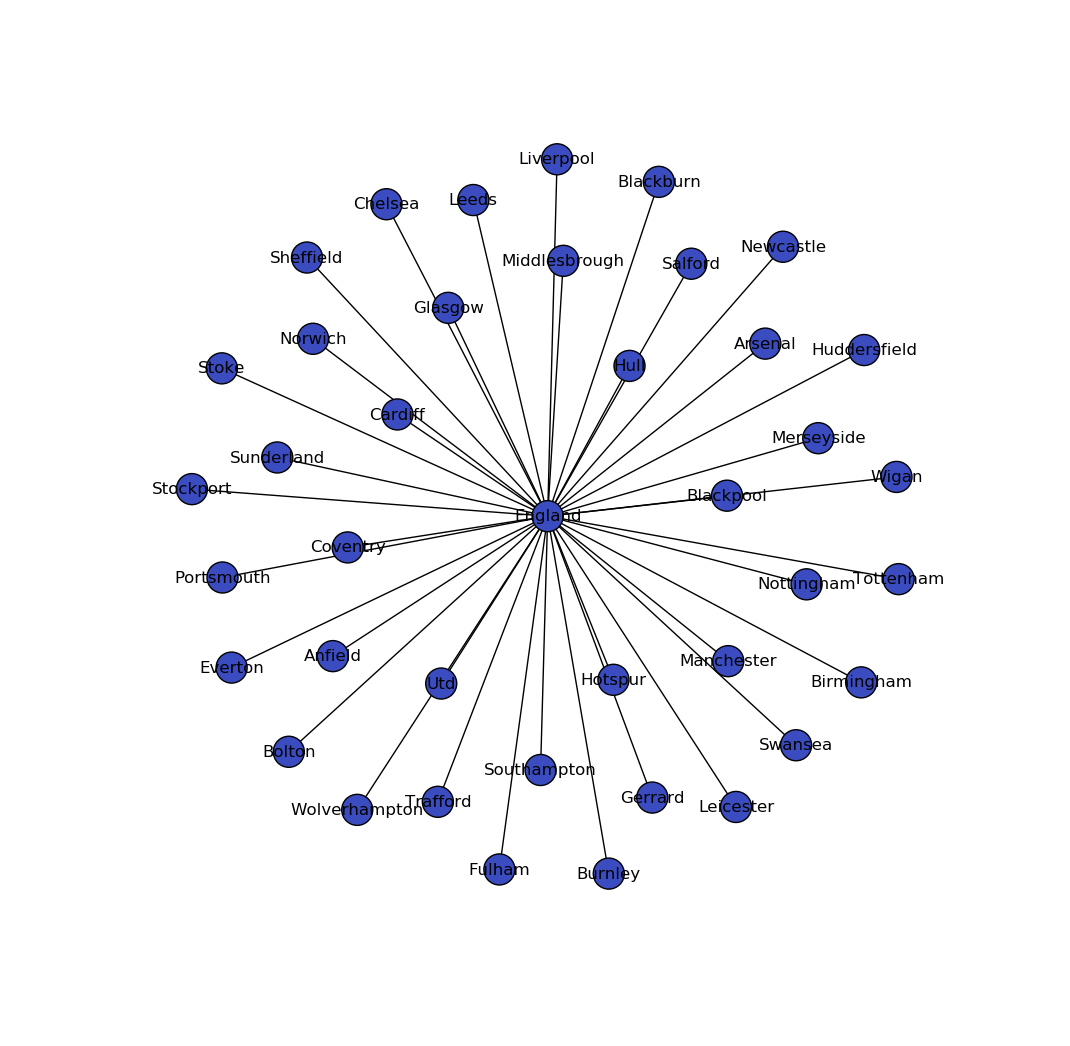

In [120]:
part = community.best_partition(edges)
values = [part.get(node) for node in edges.nodes()]

nx.draw_spring(edges, cmap = plt.get_cmap('coolwarm'), node_color = values, node_size=500, with_labels=True)
pylab.rcParams['figure.figsize'] = (10, 10)
plt.show()